In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.linalg as spla

from func import *
from math import log

## Background

Optimzation is a subset of scientific computing that has many appliations: Machine Learning, Operations Research, Business, Finance, Biology, and more. It is useful for finding the "ideal" case, usually characterizied when $f'(x) = 0$. Thus we have found a minimum (or maximum by solving $-f$).

In [2]:
def f(x):
    return x**6 +5*x**5 + 6*x**4 - 4*x**3 - 8*x**2

def df(x):
    return 6*x**5 + 25*x**4 + 24*x**3 - 12*x**2 - 16*x

def df2(x):
    return 30*x**4 + 100*x**3 + 72*x**2 - 24*x - 16

x_guess = 0.5
x_prev = -3
num_iter = 0
tol = 1e-2

x = np.linspace(-2,1.1,100)

### Newton's In 1-D

This converges quadratically with the equation:

$$ x_{k+1} = x_k - \frac{f'(x)}{f''(x)} $$

We are given the function $$x^2(x-1)(x+2)^3 = x^2(x^4 + 5x^3 + 6x^2 - 4x -8)$$

Run by clicking ctrl+enter

f(1.9285714285714286) = 209.40677818659748, previous of 0.5


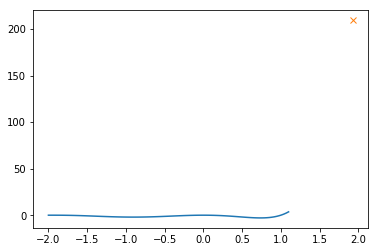

In [3]:
if(abs(x_guess - x_prev) >= tol):
    x_prev = x_guess
    x_guess = x_guess - df(x_guess)/df2(x_guess)
    print("f({}) = {}, previous of {}".format(x_guess, f(x_guess), x_prev))
    num_iter += 1
else:
    print("Took {} iterations to converge".format(num_iter))
    
plt.plot(x,f(x))
plt.plot([x_guess],[f(x_guess)], 'x', label="guess")
plt.show()

## Motivation

To our stock market, we want to only grab the "tips" of our FFT since there are many points. Our goal is to plot the graph with less points. There are a lot of points, many of which could just be noise, and want to focus only on the peaks. (See graph below)

Without optimization, finding the minimums and maximums needs to  brute force (try many equaspaced points) and check the derivative. The more points, the more accurate. However, the more points, the longer the run time.

We can devise a hueristic to solve this with (near) infinite accuracy while reducing the run time.

What we know with our interpolants is that we have a cubic polynomial for a certain domain. Rather than brute force, we can numerically solve it by find the derivative of the polynomial at that point and seeing if the roots lie within the domain it is assigned

In [4]:
stock = "amzn" # AMZN, GOOG, GOOGL, ABBV, AMGN, NKE

stock = stock.upper()
ogp = getPrices(stock)[1]

length = len(ogp)

p = ogp[:length]

equaTime = np.arange(length)
evalTime = np.linspace(0,length-1,length+1)
coeff = continousSplineCoeff(p, equaTime)

pts = evaulateCubicSpline(coeff, equaTime, evalTime)

Text(0.5, 1.0, 'Fourier Transform of Second Derivative')

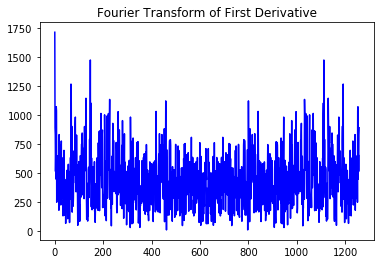

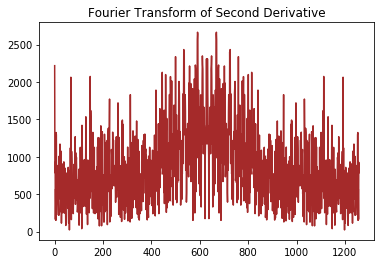

In [5]:
der1 = evaulateCubicSpline(coeff, equaTime, evalTime, order=1)
der2 = evaulateCubicSpline(coeff, equaTime, evalTime, order=2)

plt.figure(3)
der1fft = np.fft.fft(der1)
plt.plot(evalTime, abs(der1fft), color="blue")
plt.title("Fourier Transform of First Derivative")

plt.figure(5)
der2fft = np.fft.fft(der2)
plt.plot(evalTime, abs(der2fft), color="brown")
plt.title("Fourier Transform of Second Derivative")

### Generalizations

To solve this effectively, quickly, and accurately, we must make some generalizations:

#### 1. We will assume within each spline there exists at most one critical point

While there might exist up to $m$ local maximum/minumums points, we note that again, we are trying to express our FFT graph with less points, focusing on peaks. Thus, by generalizing each spline by limiting it to one CP, we can generalize the "peak" of that one region rather than try to express all $m$ peaks.

#### 2. We will assume no peak exists (which is fine) if the answer cannot be found quickly

We assume each spline region is finitely small. If we do not converge to an answer, we assume no peak is found. While we may miss $p$ peaks over the course of the entire optimization problem, we again assert we are just trying to find a generalized expression of our original function and that another peak nearby will help represent the missed peak at the current spline.

### Optimization Techniques

Some 1-D optimization, which are problems concerning maximums and minumums, techniques that come to mind are:

1. Golden Search
1. Newton

When implementing these, since we are finding critical points (solving for $x \in [start,end]$ where $f'(x) = 0$), we want to do the optimization for each of the FFT transformations.

### The Case for Newton's

We will go for Newton's Method (which was defined earlier) over Golden. Newton's is better in that if it finds the maximum/minumum, it will find it quickly (quadratically). It will also fail quickly. Since we want the fastest an not necessary the most accurate, Newton's will do great in meeting all our critea and generalizations.

### Implemenation

We need to consider a few things when implementing:

1. How to express cubic polynomial
1. When to call it quits
1. How to prevent extreme failure (divide by 0) 

Since all our polynomials' derivatives can be quickly expressed since we know their coefficients, that should be easy.

When to call it quits, we can set a hard limit on how many iterations can be run. If we cannot find it, we will leave that domain and look to the next.

As for avoiding extreme failure, we can safeguard our function by checking any division by 0. If so, we note that it is an inflection. We can either shift our search over or just leave the spline knowing the inflection point implies that the derivative is $\infty$.

In [6]:
def newtons(c0,c1,c2,c3,a,b,tol,maxTries):
    assert(a < b)
    x_prev = b
    x = a
    
    for _ in range(maxTries):
        if(x < a or x > b):
            return [False,-1,1] # exitted domain
        
        elif(abs(x - x_prev) >= tol):
            x_prev = x

            df1 = c1 + 2*c2*x + 3*c3*x**2 # 1+2t+3t^2
            df2 = 2*c2 + 6*c3*x # 2+6t
            
            if df2 == 0: return [False,-1,0] # inflection pt
            x = x - df1.real/df2.real
            
        else:
            val = c0 + c1*x + c2*x**2 + c3*x**3
            return [True,x,val] # found
        
    return [False,-1,0]

In [7]:
coeff1 = continousSplineCoeff(der1fft, evalTime)
coeff2 = continousSplineCoeff(der2fft, evalTime)

In [8]:
def findCP(coeff, time, tol=1e-1,maxTries=5):
    assert(len(coeff) == 4*(len(time)-1))
    
    numPts = len(coeff)//4
    exitTimes = 0

    tt = np.zeros(0); vv = np.zeros(0)
    for i in range(numPts-1):
        [found,t,val] = newtons(coeff[4*i],coeff[4*i+1],coeff[4*i+2],\
                                 coeff[4*i+3],time[i],time[i+1],tol,maxTries)
        if found:
            tt = np.append(tt,t)
            vv = np.append(vv,val)
        else:
            exitTimes += val
         
    print("Exitted domain {} of the {} times".format(exitTimes, len(time)))
    return [tt,vv]

def removeImg(t,v,tol):
    for i in range(len(t),0,-1):
        if t[i-1] > tol:
            continue
        else:
            return [t[:i],v[:i]]
    return [np.zeros(0),np.zeros(0)]

In [9]:
ogSize = len(coeff1)//4

tol1 = 1e-8
tol2 = 1e-8

t1,v1 = findCP(coeff1,evalTime,tol1)
print("{} domains with no critical point, found {}".format(ogSize-len(t1), len(t1)))

t2,v2 = findCP(coeff2,evalTime,tol2)
print("{} domains with no critical point, found {}".format(ogSize-len(t2), len(t2)))

# removes value on the right hand side
t1,v1 = removeImg(t1,v1,length//2)
t2,v2 = removeImg(t2,v2,length//2)

Exitted domain 657 of the 1260 times
1154 domains with no critical point, found 105
Exitted domain 679 of the 1260 times
1151 domains with no critical point, found 108


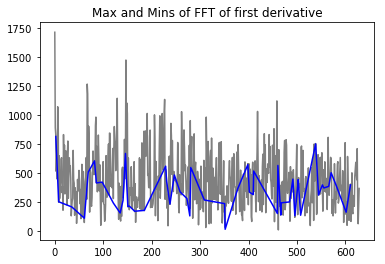

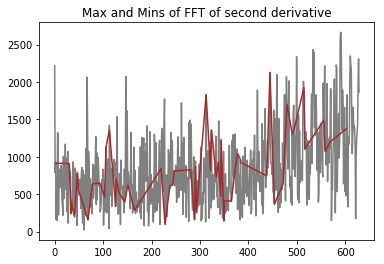

In [10]:
n1 = len(evalTime)

plt.figure(6)
plt.plot(evalTime[:n1//2], abs(der1fft[:n1//2]), color="grey")
plt.title("Fourier Transform of First Derivative")

plt.plot(t1, abs(v1),color="blue")
plt.title("Max and Mins of FFT of first derivative")

plt.figure(5)
plt.plot(evalTime[:n1//2], abs(der2fft[:n1//2]), color="grey")
plt.title("Fourier Transform of Second Derivative")

plt.title("Max and Mins of FFT of second derivative")
plt.plot(t2, abs(v2),color="brown")

### Results

As we can see here, we have a very rough approximation of our peaks from the original equation. Notice we removed the right hand values, as those tend to be symmetric.

Some further work can be done in changing the tolerance to extract the right number of points without too much noise. However, the optimization tools here are complete, and we can return our results to our FFT analysis.